# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 6
# Reg-Logistic Regression, ROC, and Data Imputation

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately): Scott Shaffer 

Enrollment Status (109A, 121A, 209A, or E109A): 109A

Import libraries:

In [9]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display, Math, Latex
%matplotlib inline

## Automated Breast Cancer Detection

In this homework, we will consider the problem of early breast cancer detection from X-ray images. Specifically, given a candidate region of interest (ROI) from an X-ray image of a patient's breast, the goal is to predict if the region corresponds to a malignant tumor (label 1) or is normal (label 0). The training and test data sets for this problem is provided in the file `hw6_dataset.csv`. Each row in these files corresponds to a ROI in a patient's X-ray, with columns 1-117 containing features computed using standard image processing algorithms. The last column contains the class label, and is based on a radiologist's opinion or a biopsy. This data was obtained from the KDD Cup 2008 challenge.

The data set contain a total of 69,098 candidate ROIs, of which only 409 are malignant, while the remaining are all normal. 

*Note*: be careful of reading/treating column names and row names in this data set.

## Question 1: Beyond Classification Accuracy


0.  Split the data set into a training set and a testing set.  The training set should be 75% of the original data set, and the testing set 25%.  Use `np.random.seed(9001)`.

1. Fit a logistic regression classifier to the training set and report the  accuracy of the classifier on the test set. You should use $L_2$ regularization in logistic regression, with the regularization parameter tuned using cross-validation. 
    1. How does the fitted model compare with a classifier that predicts 'normal' (label 0) on all patients? 
    2. Do you think the difference in the classification accuracies are large enough to declare logistic regression as a better classifier than the all 0's classifier? Why or why not?
    
For applications with imbalanced class labels, in this case when there are many more healthy subjects ($Y=0$) than those with cancer ($Y=1$), the classification accuracy may not be the best metric to evaluate a classifier's performance. As an alternative, we could analyze the confusion table for the classifier. 

<ol start="3">
<li> Compute the confusion table for both the fitted classifier and the classifier that predicts all 0's.</li>
<li> Using the entries of the confusion table compute the *true positive rate* and the *true negative rate* for the two classifiers. Explain what these evaluation metrics mean for the specific task of cancer detection. Based on the observed metrics, comment on whether the fitted model is better than the all 0's classifier.</li>
<li> What is the *false positive rate* of the fitted classifier, and how is it related to its true positive and true negative rate? Why is a classifier with high false positive rate undesirable for a cancer detection task?</li>
</ol>
*Hint:* You may use the `metrics.confusion_matrix` function to compute the confusion matrix for a classification model.

In [2]:
np.random.seed(9001)
df = pd.read_csv('./data/hw6_dataset.csv')

#  How (im)balanced is the data?
print(df['0.000000000000000000e+00'].value_counts())

msk = np.random.rand(len(df)) < 0.75
data_train = df[msk]
data_test = df[~msk]

ytrain = data_train.iloc[:,-1]
Xtrain = data_train.drop(data_test.columns[len(data_test.columns)-1], axis=1)

ytest = data_test.iloc[:,-1]
Xtest = data_test.drop(data_test.columns[len(data_test.columns)-1], axis=1)


0.0    68688
1.0      409
Name: 0.000000000000000000e+00, dtype: int64


In [3]:
logregcv = LogisticRegressionCV(penalty='l2')
logregcv.fit(Xtrain, ytrain)

print(logregcv.score(Xtest, ytest))

print(len(ytest))
all_values = len(ytest)
positive_values = np.count_nonzero(ytest)
print(np.count_nonzero(ytest))
print("Percent non-zero: ")
print(1.0-(positive_values/all_values))


0.995084269663
17088
104
Percent non-zero: 
0.9939138576779026


In [4]:
from sklearn.metrics import confusion_matrix

test_preds = logregcv.predict(Xtest)
print("Cancer cases predicted:")
print(np.count_nonzero(test_preds))
print("Actual cancer cases:")
print(positive_values)

print("Confusion Matrix:")
C = confusion_matrix(ytest, test_preds, labels=None)
print(C)

# From sklearn documentation: 
# the count of true negatives is C_{0,0}, false negatives is C_{1,0}, 
# true positives is C_{1,1} and false positives is C_{0,1}.

# Sensitivity or TPR = TP / P = TP / (TP + FN)
print("\nTrue Positive Rate:")
print(C[1][1] / (C[1][1] + C[1][0]))

# Specificity or TNR = TN / N = TN / (TN + FP)
print("\nTrue Negative Rate:")
print(C[0][0] / (C[0][0] + C[0][1]))

# FPR = FP / N = FP / (FP + TN)
print("\nFalse Positive Rate:")
print(C[0][1] / (C[0][1] + C[0][0]))


Cancer cases predicted:
36
Actual cancer cases:
104
Confusion Matrix:
[[16976     8]
 [   76    28]]

True Positive Rate:
0.269230769231

True Negative Rate:
0.999528968441

False Positive Rate:
0.000471031559114


#### Q: How does the fitted model compare with a classifier that predicts 'normal' (label 0) on all patients?

The accuracy of the fitted model using logistic regression (0.9954) is just marginally better than the accuracy of the all 0's classifier (0.9938).  Both exhibit almost near perfect accuracy (1.0), though, this is not surprising given the highly imbalanced nature of the data set (68689 - 0 and 409 - 1 for the original data set), just predict the most common response, in this case, 0.

#### Q: Do you think the difference in the classification accuracies are large enough to declare logistic regression as a better classifier than the all 0's classifier? Why or why not? 

Based on the classification accuracy metric alone, we don't think the difference in classification accuracies (0.2%) is large enough to affirm logistic regression as the better classifier.

#### Q: Explain what these evaluation metrics (true positive rate and the true negative rate) mean for the specific task of cancer detection. 

The true positive rate, also known as Sensitivity, is the ability of a test to correctly diagnose patients who have a disease (malignant tumor), given they have the disease:

$$\frac{True~Positive}{(True~Positive + False~Negative)}$$

The true negative rate, also known as Specificity, is the ability of the test to correctly diagnose patients who don’t have the disease (malignant tumor), given they do not have the disease:

$$\frac{True~Negative}{(True~Negative + False~Positive)}$$

It's worth noting that while sensitivity and specificity are easy to measure, they're not very useful in clinical practice since a clinician doesn't know if a given patient has the disease in question or not.  This is the reason why the clinician performs the diagnostic test in the first place. Instead, the clinician wants to know, given the test result, how likely is it that the patient has the disease, this is known as the positive predictive value (ppv).

#### Q: Based on the observed metrics, comment on whether the fitted model is better than the all 0's classifier.

A different picture emerges when we compare the confusion matrices, true positive rates, and true negative rates of the two classifiers.  When making comparisons, the fitted logistic regression classifier is clearly the superior model, based on comparing the true positive rates: 27% for the logistic regression classifier vs 0% for the all 0's classifier. Given that we're trying to identify a malignant tumor, a potentially fatal condition, the all 0's classifier will never predict a malignant tumor, making it a totally ineffective model.  

The true negative rates for both classifiers are almost equivalent, at or very near to 100%: 99.96% for the fitted logistic regression classifier and 100% for the all 0's classifier.  However, for such a serious condition, we'd rather have a higher true positive rates at the expense of a lower true negative rates.  While there's definitely room for improvement in the logistic regression classifier's true positive rate, anything is better than the all 0's classifier true positive rate of 0%!

#### Q: What is the *false positive rate* of the fitted classifier, and how is it related to its true positive and true negative rate? Why is a classifier with high false positive rate undesirable for a cancer detection task?

False Positive Rate is the rate of false positives (do not have cancer, but the test is positive) out of all of the "actual negatives" -- so true negatives plus false positives. This can be written as FP/(TN+FP)

$$\frac{False~Positive}{(False~Positive + True~Negative)}$$

The True Negative Rate is the rate of true negatives (people who do not have cancer, and the test is negative) over all of the actual negatives. This is equal to TN/(TN+FP), or 1 - False Positive Rate (described above)

$$ False~Positive~Rate = 1 - True~Negative~Rate$$

The True Positive Rate is the true positives over all the actual positives (people with cancer), so False Negatives + True Positives. The relationship between TPR and FPR/TNR is dependent on the classification model.

#### Q: Why is a classifier with high false positive rate undesirable for a cancer detection task?

A classifier with high false positive rate could be viewed as undesirable for a cancer detection task in the context that the patient who doesn't really have the disease (malignant tumor) will most likely undergo additional unnessary, and possibly invasive, tests/procedures and will feel stressed thinking they have the disease when they don't.

We view a high false negative rate as even more undesirable than a high false positive rate in the context of cancer detection since the mistake of not detecting cancer when it's present can have extreme negative consequences for the patient's mortality.



## Question 2: ROC Analysis

Another powerful diagnostic tool for class-imbalanced classification tasks is the Receiver Operating Characteristic (ROC) curve. Notice that the default logistic regression classifier in `sklearn` classifies a data point by thresholding the predicted class probability $\hat{P}(Y=1)$ at 0.5. By using a different threshold, we can adjust the trade-off between the true positive rate (TPR) and false positive rate (FPR) of the classifier. The ROC curve allows us to visualize this trade-off across all possible thresholds.


1. Display the ROC curve for the fitted classifier on the *test set*. In the same plot, also display the ROC curve for the all 0's classifier. How do the two curves compare?

2.  Compute the highest TPR that can be achieved by the classifier at each of the following FPR's, and the thresholds at which they are achieved. Based on your results, comment on how the threshold influences a classifier's FPR.
    - FPR = 0
    - FPR = 0.1
    - FPR = 0.5
    - FPR = 0.9
- Suppose a clinician told you that diagnosing a cancer patient as normal is *twice* as critical an error as diagnosing a normal patient as having cancer. Based on this information, what threshold would you recommend the clinician to use? What is the TPR and FPR of the classifier at this threshold? 

- Compute the area under the ROC curve (AUC) for both the fitted classifier and the all 0's classifier. How does the difference in the AUCs of the two classifiers compare with the difference between their classification accuracies in Question 1, Part 2(A)? 

*Hint:* You may use the `metrics.roc_curve` function to compute the ROC curve for a classification model and the `metrics.roc_auc_score` function to compute the AUC for the model.

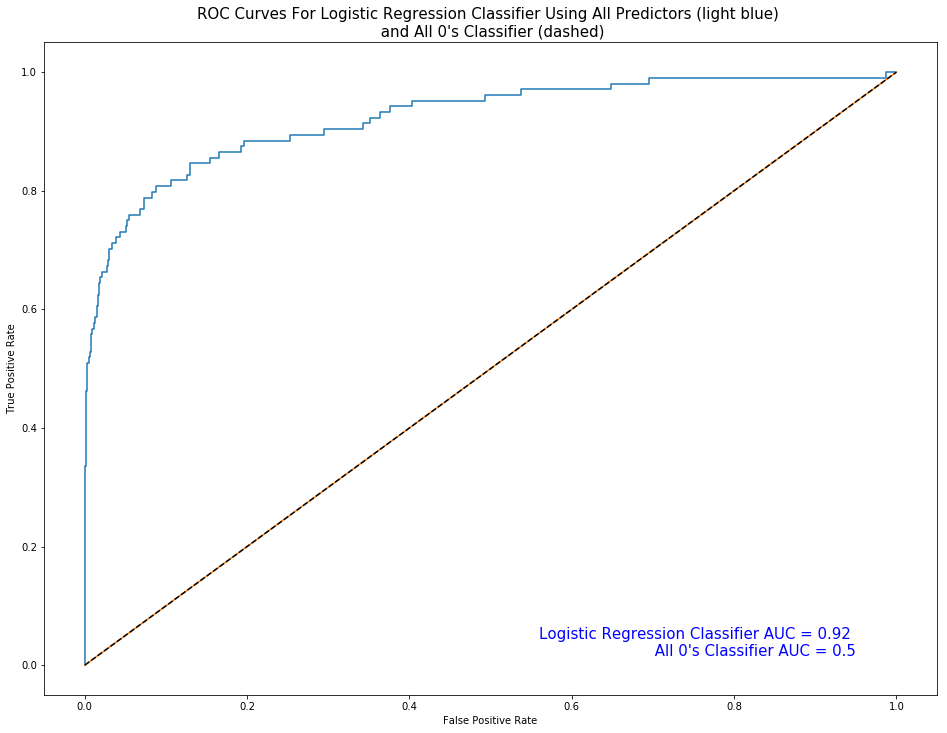

In [46]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# function to plot ROC curve from true values and model predictions
def plotROC(ytrue, ypreds):
    fpr, tpr, thresholds = roc_curve(ytrue, ypreds)
    plt.plot(fpr, tpr)

test_scores = logregcv.predict_proba(Xtest)[:,1]

# Get an array of zeros to model "always choose 0" prediction
yzeros = np.zeros(len(ytest))
plt.figure(figsize = (16, 12))

# Plot ROCs for actual test outputs and all zeros
plotROC(ytest, test_scores)
plotROC(ytest, yzeros)
plt.title('ROC Curves For Logistic Regression Classifier Using All Predictors (light blue) \n and All 0\'s Classifier (dashed)', fontsize = 15)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.txt(loc = 'best', text = roc_auc_score(ytest, test_scores))
plt.text(0.95, 0.01, 'Logistic Regression Classifier AUC = %2.2f \n All 0\'s Classifier AUC = %s' \
         % (roc_auc_score(ytest, test_scores), roc_auc_score(ytest, yzeros)),
        verticalalignment = 'bottom', 
         horizontalalignment = 'right',
         color = 'blue', 
         fontsize = 15)
plt.plot([0, 1], [0, 1], 'k--')
plt.show()


In [5]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(ytest, logregcv.predict_proba(Xtest)[:,1])


#  Compute the highest TPR that can be achieved by the classifier at each 
#  of the following FPRs, and note the thresholds at which they are achieved. 
FPRS = [0.0, 0.1, 0.5, 0.9]
#  Iterate through specified FPR thresholds
for FPR in FPRS:
    #  Iterate through false positive rate object for the 
    #  fitted logistic regression classifier.
    for ind, fpr1 in enumerate(false_positive_rate):
        # Do we cross the pecified FPR threshold?
        if fpr1 - FPR > 0:
            # Yes, then grab values
            print ("\nFPR Threshold:            " + str(FPR))
            print ("False Positive Rate:      " + str(false_positive_rate[ind]))
            print ("True Positive Rate:       " + str(true_positive_rate[ind]))
            print ("Predicted Class\nProbability Threshold:    " + str(thresholds[ind]))
            print ("Index:                    " + str(ind))
            break


FPR Threshold:            0.0
False Positive Rate:      5.88789448893e-05
True Positive Rate:       0.0
Predicted Class
Probability Threshold:    0.999904808579
Index:                    1

FPR Threshold:            0.1
False Positive Rate:      0.10633537447
True Positive Rate:       0.807692307692
Predicted Class
Probability Threshold:    0.00566066055547
Index:                    113

FPR Threshold:            0.5
False Positive Rate:      0.537976919454
True Positive Rate:       0.961538461538
Predicted Class
Probability Threshold:    0.000152379283602
Index:                    147

FPR Threshold:            0.9
False Positive Rate:      0.987635421573
True Positive Rate:       0.990384615385
Predicted Class
Probability Threshold:    6.7004874287e-09
Index:                    157


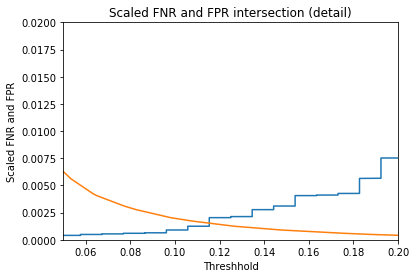

In [6]:
# Draw a plot at the point at which 
# diagnosing a cancer patient as normal is twice as bad as diagnosing a normal patient with cancer
# That is: False negative rate needs to be half false positive rate FNR = 1/2 FPR
# FNR = 1-TPR
# 1 - TPR = 1/2 FPR
fpr, tpr, thresholds = roc_curve(ytest, test_scores)
plt.plot(1-tpr, thresholds, label='FNR')
plt.plot(0.5*fpr, thresholds, label='0.5 * FPR')
plt.title("Scaled FNR and FPR intersection (detail)")
plt.xlabel('Threshhold')
plt.ylabel('Scaled FNR and FPR')
plt.xlim(0.05, 0.2)
plt.ylim(0.0, 0.02)
plt.show()



In [10]:
#    Computed mathematically...
#    Diagnosing a cancer patient as normal is twice as critical an error as 
#    diagnosing a normal patient as having cancer.
#     ==> One False Negative is 2 times less desirable than One False Positive
#    Determine the classification threshold corresponding to this

threshold = 0.0
# Iterate through theshold range
for threshold in np.arange(0.0, 1.0, 0.001):
    # Determine FN and FP from confusion matrix at specified threshold
    tn_logregCV, fp_logregCV, fn_logregCV, tp_logregCV = confusion_matrix(ytest, 
                                                                      (np.round(logregcv.predict_proba(Xtest)[:,1] - threshold + 0.5)),
                                                                      labels = None).ravel()
    #  Is False Positive // False Negative = 2?
    if ( fp_logregCV % fn_logregCV == 0)  and ( fp_logregCV // fn_logregCV == 2):
        # Yes, display threshold, FN, and FP
        print ("Threshold:        " + str(threshold))
        print ("False Negative:   " + str(fn_logregCV))
        print ("False Positive:   " + str(fp_logregCV))
        break
print ("\n\nTest Confusion Matrix at threshold: " + str(threshold))
print (confusion_matrix(ytest, (np.round(logregcv.predict_proba(Xtest)[:,1] - threshold + 0.5)),labels = None))
tpr_logregCV = tp_logregCV/(tp_logregCV + fn_logregCV)
fpr_logregCV = fp_logregCV/(fp_logregCV + tn_logregCV)

# Compute true positive rate of the fitted classifier at threshold
print ("\ntrue positive rate at threshold " + str(threshold) + " :  " + str(tpr_logregCV))

# Compute false positive rate of the fitted classifier at threshold
fpr_logregCV = fp_logregCV/(fp_logregCV + tn_logregCV)
print ("\nfalse positive rate at threshold " + str(threshold) + ":  " + str(fpr_logregCV))




/Users/sshaffer/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


Threshold:        0.116
False Negative:   50
False Positive:   100


Test Confusion Matrix at threshold: 0.116
[[16884   100]
 [   50    54]]

true positive rate at threshold 0.116 :  0.519230769231

false positive rate at threshold 0.116:  0.00588789448893


#### Q: How do the two ROC curves compare?

The fitted classifier ROC curve is much better, its True Positive values are always larger than the all 0's classifier ROC curve values for any given False Positive value, or, put another way, tends toward the upper left quadrant of the plot more than the all 0's classifier ROC curve.  The all 0's classifier ROC curve is a straight line with slope = 1 and y-intercept at x = 0.  This is equivalent to a truly random (and therefore very poor) classifier, meaning, it's no better at identifying true positives than flipping a coin.  Such as classifier will have an area under the ROC curve (AUC) of 0.5, the lowest possible AUC.

#### Q: Compute the highest TPR that can be achieved by the classifier at each of the following FPR's, and the thresholds at which they are achieved. Based on your results, comment on how the threshold influences a classifier's FPR. Based on your results, comment on how the threshold influences a classifier's FPR.
    
  
FPR | TPR |  Predicted Class<br> Probability Threshold|
-------------:|-------------:|-------------:|
0 | 0.0|0.9999|
0.1| 0.8077|0.0057|
0.5| 0.9615|0.0002|
0.9| 0.9904|6.7004874287e-09|

Lowering the predicted class probability threshold corresponds to increasing the classifier's false positive rate (FPR).

#### Q: Suppose a clinician told you that diagnosing a cancer patient as normal is twice as critical an error as diagnosing a normal patient as having cancer. Based on this information, what threshold would you recommend the clinician to use? What is the TPR and FPR of the classifier at this threshold?

Based on this criteria, we took two approaches:

**1)** *Visual approach* - We constructed a figure, see above, that consists of two plots, FNR and FPR both scaled corresponding to meet the clinician's criteria.  We could then visually determine the point at which the two plots intersect, this corresponds to the predicted class probability threshold at which diagnosing a cancer patient as normal is twice as bad as diagnosing a normal patient with cancer.

**2)** *Iterative approach* - We iterate through a range of predicted class probability thresholds between 0 and 1 to determine at which threshold the ratio of the number of False Positives to False Negative is 2.  

Both the visual and iterative approach produced a predicted class probability threshold of 0.116, and we verified our fitted model yields 50 False Negatives and 100 False Positive when we use this threshold.  The TPR and FPR of the classifier at this threshold is 0.5192 and 0.0059, respectively.

#### Q; Compute the area under the ROC curve (AUC) for both the fitted classifier and the all 0's classifier. How does the difference in the AUCs of the two classifiers compare with the difference between their classification accuracies in Question 1, Part 2(A)?

The area under the ROC curve (AUC) for both the fitted classifier and the all 0's classifier is 0.93 and 0.5, respectively, as shown in the ROC plot.  An AUC of 0.5 is the lowest possible AUC and it corresponds to a truly random (and very poor) classifier as implied earlier.  Recall, the classification accuracies for both classifiers in Question 1, Part 2(A) were almost identical at ~99%.  AUC is a a better (more approproiate) quantitative metric to assess and compare binary classifier performance(s).



## Question 3: Missing data

In this problem you are given a different data set, `hw6_dataset_missing.csv`, that is  similar to the one you used above (same column definitions and same conditions), however this data set contains missing values. 

*Note*: be careful of reading/treating column names and row names in this data set as well, it *may* be different than the first data set.


1. Remove all observations that contain any missing values, split the dataset into a 75-25 train-test split, and fit the regularized logistic regression as in Question 1 (use `LogisticRegressionCV` again to retune).  Report the overall classification rate and TPR in the test set.
2. Restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via mean imputation.  Split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
3. Again restart with a fresh copy of the data in `hw6_dataset_missing.csv` and impute the missing data via a model-based imputation method. Once again split the data 75-25 and fit the regularized logistic regression model.  Report the overall classification rate and TPR in the test set.  
4. Compare the results in the 3 previous parts of this problem.  Prepare a paragraph (5-6 sentences) discussing the results, the computational complexity of the methods, and conjecture and explain why you get the results that you see.



In [11]:
from sklearn.metrics import confusion_matrix

def split_data(df):
    # Split data into 25-75 train and test data
    np.random.seed(9001)
    msk = np.random.rand(len(df)) < 0.75
    data_train = df[msk]
    data_test = df[~msk]
    
    # set y data to just the last column, remove last column from the predictor sets
    ytrain = data_train.iloc[:,-1]
    Xtrain = data_train.drop(data_test.columns[len(data_test.columns)-1], axis=1)

    ytest = data_test.iloc[:,-1]
    Xtest = data_test.drop(data_test.columns[len(data_test.columns)-1], axis=1)
    return (ytrain, Xtrain, ytest, Xtest)
    
def split_and_test(df):
    # Get all four sets from split data function
    ytrain, Xtrain, ytest, Xtest = split_data(df)
    # Perform logistic regression, then fit and score
    logregcv = LogisticRegressionCV(penalty='l2')
    logregcv.fit(Xtrain, ytrain)
    print("\nScore:")
    print(logregcv.score(Xtest, ytest))
    test_preds = logregcv.predict(Xtest)
    C = confusion_matrix(ytest, test_preds)
    print("Confusion Matrix:")
    print(C)

    print("True Positive Rate:")
    print(C[1][1] / (C[1][1] + C[1][0]))


In [13]:
df_missing = pd.read_csv('./data/HW6_dataset_missing.csv')
missing_columns = df_missing.columns[df_missing.isnull().any()]
# How many NaNs are there in each column with missing data?
df_missing[missing_columns].isnull().sum()


93     3894
94     3903
95     3897
96     3913
97     3899
98     3903
99     3911
100    3907
101    3889
102    3953
103    3911
104    3928
105    3891
106    3892
107    3928
108    3909
109    3914
dtype: int64

In [14]:
#Drop missing datapoints
df_dropped = df_missing.dropna(axis=0, how='any', inplace=False)
split_and_test(df_dropped)

/Users/sshaffer/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)



Score:
0.994382022472
Confusion Matrix:
[[354   0]
 [  2   0]]
True Positive Rate:
0.0


In [15]:
#  Restart with a fresh copy of the data in hw6_dataset_missing.csv and 
#  impute the missing data via a model-based imputation method. 
#  Split the data 75-25 and fit the regularized logistic regression model. 
#  Report the overall classification rate and TPR in the test set.
#  Determine which columns contain NaNs

#df = pd.read_csv('./data/HW6_dataset_missing.csv')
#df_full = df.copy()  
#df_full.dropna(axis=0, how='any', inplace=True)  # df_full contains no NaNs
df_mean = df_missing.copy()

# Iterate through columns with Nan
for missing_column in missing_columns:
    # Find means of those columns
    df_mean[missing_column] = df_missing[missing_column].fillna(df_mean[missing_column].mean())
split_and_test(df_mean)


Score:
0.992653061224
Confusion Matrix:
[[6072    2]
 [  43    8]]
True Positive Rate:
0.156862745098


In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
# Again restart with a fresh copy of the data in hw6_dataset_missing.csv and 
# impute the missing data via a model-based imputation method. 
# Once again split the data 75-25 and fit the regularized logistic regression model. 
# Report the overall classification rate and TPR in the test set.

# Remove predictor
df_full = df_missing.copy()
df_impute = df_missing.copy()

#Drop missing rows
df_full.dropna(axis=0, how='any', inplace=True)  # df_full contains no NaNs
# Drop missing columns for X_imp predictions
X_imp  = df_full.drop(missing_columns, axis = 1)

# Iterate through previously-found columns with Nan
for missing_column in missing_columns:
    #  Build linear regression model using dataset without columns containing NaNs
    y_imp  = df_full[missing_column]

    linreg = LinearRegression()
    linreg.fit(X_imp, y_imp)
    
    y_hat = linreg.predict(X_imp)

    #  Get rows with missing indexes and then Drop column we're trying to impute
    X_missing_rows_df = df_missing[df_missing[missing_column].isnull()]
    X_missing_indexes = df_missing[df_missing[missing_column].isnull()].index

    X_missing_rows_df = X_missing_rows_df.drop(missing_columns, axis = 1)

    y_missing_rows = linreg.predict(X_missing_rows_df)

    y_missing_noise = y_missing_rows + np.random.normal(loc = 0,
                                                   scale = np.sqrt(mean_squared_error(y_imp,y_hat)),
                                                   size  = y_missing_rows.shape[0])
    missing_series = pd.Series(data = y_missing_noise, index = X_missing_indexes)
    
    #back to the data set with missingness and impute the predictions
    df_impute[missing_column] = df_impute[missing_column].fillna(missing_series)

split_and_test(df_impute)




Score:
0.992653061224
Confusion Matrix:
[[6071    3]
 [  42    9]]
True Positive Rate:
0.176470588235


#### Q: Remove all observations that contain and missing values, split the dataset into a 75-25 train-test split, and fit the regularized logistic regression as in Question 1. Report the overall classification rate and TPR in the test set.

Overall classification rate: 0.994
True positive rate: 0.0

#### Q: Restart with a fresh copy of the data in hw6_dataset_missing.csv and impute the missing data via mean imputation. Split the data 75-25 and fit the regularized logistic regression model. Report the overall classification rate and TPR in the test set.

Overall classification rate: 0.993
True positive rate: 0.157

#### Q: Impute the missing data via a model-based imputation method. Once again split the data 75-25 and fit the regularized logistic regression model. Report the overall classification rate and TPR in the test set.

Overall classification rate: 0.993
True positive rate: 0.176

#### Q: Compare the results in the 3 previous parts of this problem. Prepare a paragraph (5-6 sentences) discussing the results, the computational complexity of the methods, and conjecture and explain why you get the results that you see.

All three of the correct classification rates were very similar, differing only by a tenth of a percent. Removing the missing values produced the best classification rate at 0.994, but with no true positive values (true positive rate of 0.0). Because there was so little remaining data to work with, the classification rate may be artifically high as a result of overfitting to less data, as compared with the other two methods.

Mean imputation decreased the correct classification rate slightly and provided a better true positive rate, although it was still at only 15.7%. 

Using a model based imputation method increased the true positive rate (17.6%) as well as the classification rate. However the complexity of the model -- which required a linear regression for each predictor -- increased dramatically over the mean imputation model. The mean imputation model produced a good result, preserved data (as compared with the "discard rows with missing data" method), and did not require much additional calculation over doing a straightforward logistic regression with cross validation.

